# G4CNPTEPC Particle identification using the ΔE-E technique 
By Andrei R. Hanu - <andrei.hanu@nasa.gov>

## Introduction
The primary goal of the CNP-TEPC development is to develop a dosimeter that has isotropic sensitivity to radiation and the capability to discriminate charged particle and neutral interactions in real-time. 

The ΔE-E technique is a well known particle identification technique within the cosmic ray community and applicable when energetic particles with kinetic energy E pass through two or more detector layers and are stopped. The distribution of energy depositions ΔE within the detectors layers is different for different particles due to their different stopping powers.

In [15]:
# Matplotlib - 2D plotting library
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from mpl_toolkits.axes_grid1 import ImageGrid

# Show matplotlib figures inline the notebook
%matplotlib inline

# Pandas - High-performance data analysis
import pandas

# Glob - Unix style pathname pattern expansion
# Used to aggregate folders and files into a single list so they can be iterated over
import glob

# Numpy - For handling of large, multi-dimensional arrays and matrices
import numpy as np

# System calls
import sys

# Color palette library for Python
# How to choose a colour scheme for your data:
# http://earthobservatory.nasa.gov/blogs/elegantfigures/2013/08/05/subtleties-of-color-part-1-of-6/
import brewer2mpl

# Divide integers
from __future__ import division

##########################################################################################
# Setting rcParams for publication quality graphs
fig_width_pt = 246.0                    # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # Width in inches
fig_height = fig_width*golden_mean      # Height in inches
fig_size =  [fig_width, fig_height]
# fig_size =  [7.3,4.2]
fig_size =  [7.3*1.25,4.2*1.25]
# fig_size =  [7.3*1.5,4.2*1.5]
# fig_size =  [7.3*2,4.2*2]
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'legend.fontsize': 9,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'xtick.major.size': 6,
        'xtick.major.width': 1,
        'xtick.minor.size': 2.5,
        'xtick.minor.width': 1,
        'ytick.major.size': 6,
        'ytick.major.width': 1,
        'ytick.minor.size': 2.5,
        'ytick.minor.width': 1,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Avant Garde',
        'font.size': 10,
        'text.usetex': True,
        'figure.figsize': fig_size}

# Update rcParams
rcParams.update(params)

In [16]:
##########################################################################################
# Energy of incident particles (Neutrons)
# InputEnergies = np.array([np.linspace(100,900, num=9, endpoint=True, dtype = int),
#                           np.linspace(1000,9000, num=9, endpoint=True, dtype = int),
#                           np.linspace(10000,90000, num=9, endpoint=True, dtype = int)
#                 ]).flatten()

InputEnergies = np.logspace(3.0, 5.0, num=40).astype(int)

# Folder containing simulation data
DataFolder = '../Results/Scint_4mm_PV_1mm_Lid_1mm/Electrons/'

# Print a list of input electron energies
# InputEnergies = InputEnergies[0:30]
print "Input Electron Energies: ", InputEnergies
# for InputEnergy in InputEnergies[InputEnergies.argsort()]:
#     print InputEnergy/1E3, "\t"

Input Electron Energies:  [  1000   1125   1266   1425   1603   1804   2030   2285   2571   2894
   3257   3665   4124   4641   5223   5878   6614   7443   8376   9426
  10608  11937  13433  15117  17012  19144  21544  24244  27283  30702
  34551  38881  43754  49238  55410  62355  70170  78965  88862 100000]


In [17]:
##########################################################################################
# Custom 2D energy histogramming function used to generate the particle identification 
# plot
def hist2D_E1E2(E1,E2,E1_range,E2_range,E1_bins,E2_bins):
    """ 
    The following helper function can be used to perform 2D histogram binning for the ΔE-E 
    plots
    
    E1 and E2 are energy input lists
    E1_range define the range of E1 energy bins
    E2_range define the range of E2 energy bins
    
    E1_bins and E2_bins specifies the # of bins within the range
    """
    # Compute the E1-width
    E1_min,E1_max = E1_range
    E1_min = float(E1_min)
    E1_max = float(E1_max)
    E1_width = E1_max-E1_min
    
    # Compute the E2-width
    E2_min,E2_max = E2_range
    E2_min = float(E2_min)
    E2_max = float(E2_max)
    E2_width = E2_max-E2_min
    
    # Sub functions to find the E1 & E2 bin indices
    def E1_bin(E1val):
        return np.floor(E1_bins*(E1val-E1_min)/E1_width) if E1_min <= E1val < E1_max else float(E1_bins-1) if E1val >= E1_max else 0. if E1val < E1_min else None
    
    def E2_bin(E2val):
        return np.floor(E2_bins*(E2val-E2_min)/E2_width) if E2_min <= E2val < E2_max else float(E2_bins-1) if E2val >= E2_max else 0. if E2val < E2_min else None
    
    # Create an empty histogram
    hist_E1E2 = np.zeros((E1_bins,E2_bins)) 
    
    # Fill the histogram
    for dE1,dE2 in zip(E1,E2):
        i_E1,i_E2 = E1_bin(dE1),E2_bin(dE2)
        
        if i_E1 is not None and i_E2 is not None:
            hist_E1E2[i_E1,i_E2] += 1 
        
    extent = (E1_min,E1_max,E2_min,E2_max)
    pixelSize = (E1_width/E1_bins,E2_width/E2_bins)
    
    return hist_E1E2,extent,pixelSize

In [18]:
##########################################################################################
# Loop through the simulation data for each input energy and 
# calculate the ΔE-E energy histogram

# Specify the histogram parameters (Energy in eV)
dE_ACD_range = (1E5, 1E7)
dE_ACD_bins = 100
dE_TEPC_range = (0., 1E3)
dE_TEPC_bins = 1000

# Create an empty 2D Numpy array to histogram dE_ACD vs electron energy
Hist_dE_ACD = np.zeros((dE_ACD_bins,InputEnergies.shape[0]), dtype=np.int)
Hist_dE_TEPC = np.zeros((dE_TEPC_bins,InputEnergies.shape[0]), dtype=np.int)
iHist = 0

# Loop through the input energies to process the data
for InputEnergy in InputEnergies[InputEnergies.argsort()]:
    # Create data file template from current energy 
    DataFilename = 'e-_' + str(InputEnergy) + 'keV_Nr_*_ISO_nt_G4CNPTEPC_t*.csv*'
    
    ##########################################################################################
    # Process the simulation data files
    # Column 0 - Energy deposited in the TEPC sensitive volume [eV]
    # Column 1 - Track length of particles that entirely traverse the TEPC [mm]
    # Column 2 - Energy deposited in the plastic scintillator [eV]
    for dataFile in glob.glob(DataFolder + DataFilename):  
        # Readout CSV files
        try:
            dataFrame = pandas.read_csv(dataFile, compression='gzip', header=-1, skiprows=6,
                                       names=('dE_TEPC',
                                       'trackLength_TEPC',
                                       'dE_ACD'))
#             dataFrame = pandas.read_csv(dataFile, header=-1, skiprows=6, usecols=[0,2]).values

#             print dataFrame.head()
            # Histogram the dE_ACD
            Hist_dE_ACD[:,iHist] += np.histogram(dataFrame.dE_ACD,
                                                 bins=dE_ACD_bins,
                                                 range=dE_ACD_range,
                                                 normed=False, 
                                                 weights=None, 
                                                 density=None)[0]
        
            # Histogram the dE_TEPC
            Hist_dE_TEPC[:,iHist] += np.histogram(dataFrame.dE_TEPC,
                                                 bins=dE_TEPC_bins,
                                                 range=dE_TEPC_range,
                                                 normed=False, 
                                                 weights=None, 
                                                 density=None)[0]
            

#             print np.column_stack((dataFrame[:,0],dataFrame[:,2]))
            # Pass this data frame through the histogramming routine
#             PID_Hist, PID_extent, PID_pixelSize = hist2D_E1E2(dataFrame.dE_TEPC,dataFrame.dE_ACD,E1_range,E2_range,E1_bins,E2_bins)
        
        except:
            print "Failed to process " + dataFile.split('/')[-1] + " (Exception: " + sys.exc_info()[0].__name__ + ")"
            pass
    
    # Let me know when all the data files for a given energy have been processed
    print 'Finished processing data files for', InputEnergy, 'keV'
    
    # Increment the current Histogram index
    iHist += 1

Finished processing data files for 1000 keV
Finished processing data files for 1125 keV
Finished processing data files for 1266 keV
Finished processing data files for 1425 keV
Finished processing data files for 1603 keV
Finished processing data files for 1804 keV
Finished processing data files for 2030 keV
Finished processing data files for 2285 keV
Finished processing data files for 2571 keV
Finished processing data files for 2894 keV
Finished processing data files for 3257 keV
Finished processing data files for 3665 keV
Finished processing data files for 4124 keV
Finished processing data files for 4641 keV
Finished processing data files for 5223 keV
Finished processing data files for 5878 keV
Finished processing data files for 6614 keV
Finished processing data files for 7443 keV
Finished processing data files for 8376 keV
Finished processing data files for 9426 keV
Finished processing data files for 10608 keV
Finished processing data files for 11937 keV
Finished processing data files

In [19]:
print Hist_dE_ACD[:,0]
print Hist_dE_TEPC[:,0]

[13 15 13 12  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 3 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 2 1 0 0 1 3 0 3 0 2 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 2 0 0 2 4 1 3 2 0
 1 0 2 0 0 1 1 0 1 3 0 0 1 2 1 1 1 0 0 0 0 0 1 1 1 1 3 0 2 0 1 1 1 1 0 0 1
 1 0 2 0 0 1 1 0 0 1 1 0 3 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 2 1 0 1 1 0 2 0
 1 1 0 0 0 2 1 1 0 0 2 3 0 1 2 2 0 1 3 0 1 1 2 1 2 1 4 0 0 2 1 0 1 0 0 0 3
 0 0 0 0 0 0 0 1 2 1 3 1 1 0 0 1 0 0 0 2 1 1 0 0 1 3 1 1 0 0 0 1 1 2 1 3 1
 1 1 0 1 0 0 1 0 1 0 0 2 0 2 3 0 0 1 1 0 3 0 1 0 0 1 0 0 1 3 0 0 1 0 0 0 0
 1 1 1 0 0 1 1 0 1 2 0 1 0 1 1 1 1 2 4 0 2 2 1 1 1 0 1 1 1 0 1 2 0 0 1 1 1
 1 1 0 0 1 1 0 1 0 0

Plot saved to: ../Results/Scint_4mm_PV_1mm_Lid_1mm/Electrons/Hist_dE_ACD.pdf


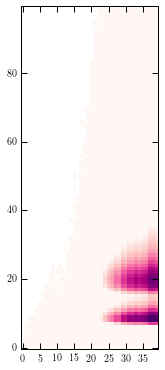

In [20]:
# Create histogram
fig_dE_ACD, ax_dE_ACD = plt.subplots(1,1)
                
# Color map
cmap = brewer2mpl.get_map('RdPu', 'sequential', 9, reverse=False).mpl_colormap
# cmap.set_under('white')
# cmap.set_over('black')

# Plot the projections
H = ax_dE_ACD.imshow(Hist_dE_ACD, 
                     cmap = cmap, 
                     interpolation='none', 
                     origin='lower',
                     norm=colors.LogNorm(Hist_dE_ACD.mean() + 0.5 * Hist_dE_ACD.std(), Hist_dE_ACD.max(), clip='False')) 
# grid_dEE_Hist[0].set_xscale('log')
# grid_dEE_Hist[0].set_yscale('log')

# Information Text
# grid_dEE_Hist[0].text(0.05, 0.95,'EventID: ' + str(EventID[0])  + '\nAr + CO$_2$ (80/20) \n $\\rho$ = 1.795 mg/cm$^3 (STP)$ \n Voxel = (0.8 mm)$^3$ \n E$_\gamma$ = 10 MeV', horizontalalignment='left', verticalalignment='top', transform=gridTrack[0].transAxes)

# Figure Properties
# grid_dEE_Hist[0].set_xlabel('X (mm)')
# grid_dEE_Hist[0].set_ylabel('Z (mm)') 

# xTicks = np.array([-750,-500,-250,0,250,500,750])
# yTicks = np.array([-750,-500,-250,0,250,500,750])

# grid_dE_E_Hist[0].set_xticks(xTicks) 
# grid_dE_E_Hist[0].set_yticks(yTicks)  

# With cbar_mode="single", cax attribute of all axes are identical.
#cbar = plt.colorbar(H1, cax = gridTrack.cbar_axes[0])
#cbar.solids.set_edgecolor("face")
#cbar.ax.set_ylabel('Energy Deposited (eV)')

#for cax in gridTrack.cbar_axes:
#    cax.toggle_label(True)

# Tight Layout
plt.tight_layout()

# Save the figure 
file_dE_ACD = 'Hist_dE_ACD.pdf'
plt.savefig(DataFolder + file_dE_ACD, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_dE_ACD)

# Show the figure
plt.show(fig_dE_ACD)

Plot saved to: ../Results/Scint_4mm_PV_1mm_Lid_1mm/Electrons/Hist_dE_TEPC.pdf


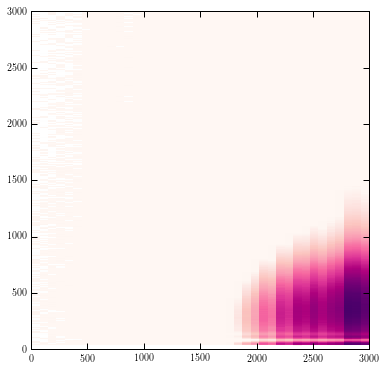

In [29]:
# Create the dE_TEPC histogram
fig_dE_TEPC, ax_dE_TEPC = plt.subplots(1,1)
                
# Color map
cmap = brewer2mpl.get_map('RdPu', 'sequential', 9, reverse=False).mpl_colormap
# cmap.set_under('white')
# cmap.set_over('black')

# Plot the projections
H = ax_dE_TEPC.imshow(Hist_dE_TEPC, 
                     cmap = cmap, 
                     interpolation='none', 
                     origin='lower',
                     norm=colors.LogNorm(Hist_dE_TEPC.mean() + 0.5 * Hist_dE_TEPC.std(), Hist_dE_TEPC.max(), clip='False'),
                     extent=(0,3000,0,3000)) 

# Tight Layout
plt.tight_layout()

# Save the figure 
file_dE_TEPC = 'Hist_dE_TEPC.pdf'
plt.savefig(DataFolder + file_dE_TEPC, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_dE_TEPC)

# Show the figure
plt.show(fig_dE_TEPC)

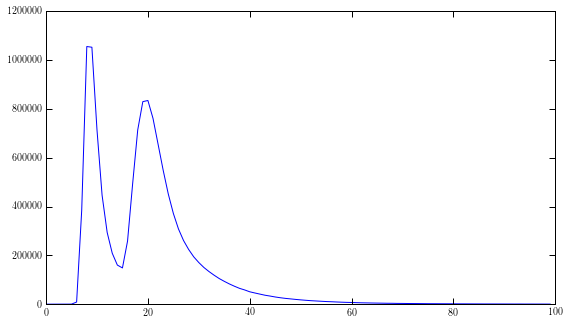

In [22]:
plt.plot(Hist_dE_ACD[:,30])